In [1]:
import requests

class UNdataClient:
    def __init__(self, base_url="http://data.un.org/ws/rest"):
        self.base_url = base_url

    def get_dataflows(self):
        """
        Get a list of available dataflows.
        """
        endpoint = f"{self.base_url}/dataflow/all/all/latest"
        
        headers = {
            "Accept": "application/vnd.sdmx.structure+json;version=1.0"
        }

        response = requests.get(endpoint, headers=headers)
        
        if response.status_code == 200:
            return response.json()
        else:
            response.raise_for_status()

In [15]:
client = UNdataClient()
r_json = client.get_dataflows()
dataflows = r_json['data']['dataflows']
print(f"Found n:{len(dataflows)} datasets")
for dataflow in dataflows:
    print(f"- {dataflow.get('id')}: {dataflow.get('name', 'No name available')}")

Found n:15 datasets
- DF_SEEA_AEA: Air emission accounts
- DF_SEEA_ENERGY: Physical energy flow accounts
- NASEC_IDCFINA_A: Annual financial accounts
- NASEC_IDCFINA_Q: Quarterly financial accounts
- NASEC_IDCNFSA_A: Annual non-financial accounts
- NASEC_IDCNFSA_Q: Quarterly non-financial accounts
- NA_MAIN: NA Main Aggregates
- DF_UNDATA_MDG: SDMX-MDGs
- DF_SDG_GLH: SDG Harmonized Global Dataflow
- DF_UNData_UIS: SDMX_UIS_UNData
- DF_UNDATA_COUNTRYDATA: SDMX-CountryData
- DF_UNDATA_ENERGY: UNSD Energy Statistics
- DF_UNData_EnergyBalance: Energy Balance DataFlow
- DF_UNData_UNFCC: SDMX_GHG_UNDATA
- DF_UNDATA_WDI: WB World Development Indicators


# Com Trade

In [237]:
import pandas
import requests
import comtradeapicall

api_key = "b1a3f42948df4538a17418bdfdc5574a"

import bizwiz
path_manager = bizwiz.PathManager(
    data_dir = "../data/un_data/"
)

## Find a country code

We will first search ISO country codes

after finding a ISO code we will convert it to a comtrade data format

In [238]:
import csv
from typing import List, Tuple
from fuzzywuzzy import process

def load_country_data(file_path: str) -> List[Tuple[str, str, str]]:
    """
    Load country data from a CSV file.
    
    :param file_path: Path to the CSV file containing country data
    :return: List of tuples containing (country name, alpha-2 code, alpha-3 code)
    """
    countries = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header row
        for row in reader:
            countries.append((row[0], row[1], row[2]))
    return countries

def fuzzy_search_country(query: str, countries: List[Tuple[str, str, str]], limit: int = 5) -> List[Tuple[str, str, str, int]]:
    """
    Perform a fuzzy search on country names and return matching countries with their ISO codes.
    
    :param query: Search query string
    :param countries: List of country data tuples
    :param limit: Maximum number of results to return
    :return: List of tuples containing (country name, alpha-2 code, alpha-3 code, match score)
    """
    country_names = [country[0] for country in countries]
    matches = process.extract(query, country_names, limit=limit)
    
    results = []
    for match in matches:
        country_name, score = match
        index = country_names.index(country_name)
        country_data = countries[index]
        results.append((*country_data, score))
    
    return results

In [239]:
filepath = path_manager.get_data_file(filename='country_data.csv')
countries = load_country_data(filepath)
    
search_query = 'china'
threshold = 80
results = fuzzy_search_country(search_query, countries)
print(f"\nTop matches for '{search_query}':")
for country, alpha2, alpha3, score in results:
    if score>=threshold:
        print(f"{country} (ISO: '{alpha3}') - Match score: {score}")


Top matches for 'china':
China (ISO: 'CHN') - Match score: 100


In [240]:
country_isos = [
    'SWE',
    'CAN',
    'CHN',
]
reporter_codes = {}
for iso in country_isos:
    code = comtradeapicall.convertCountryIso3ToCode(iso)
    print(f"ISO: '{iso}' -> reporterCode: {code}")
    reporter_codes[iso] = int(code)

ISO: 'SWE' -> reporterCode: 752
ISO: 'CAN' -> reporterCode: 124
ISO: 'CHN' -> reporterCode: 156


## Find Data Availability

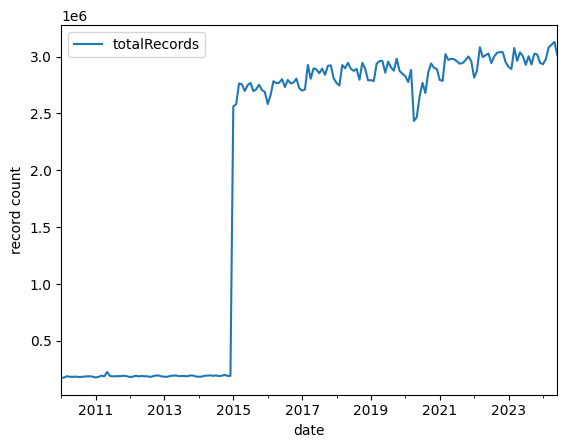

In [241]:
#check what historical data exists for a country
reporter_code = 124 #cananda

#what months data is available for
df = comtradeapicall.getFinalDataAvailability(
    subscription_key=api_key,
    typeCode='C',freqCode='M',clCode='HS',
    reporterCode=reporter_code,
    period=None
)
#plot the period x axis, count y axis
df['date'] = pd.to_datetime(df['period'], format='%Y%m')
ax = df.plot(x='date', y='totalRecords', ylabel='record count')

In [242]:
#choose a date range for the dataset
def filter_date_range(df, start_date, end_date, date_column='date'):
    """
    Filter a pandas DataFrame to include only rows where the date_column
    is between start_date and end_date (inclusive).

    date format 'YYYY-MM-DD'
    """
    # Convert string dates to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Filter the DataFrame
    mask = (df[date_column] >= start_date) & (df[date_column] <= end_date)
    return df.loc[mask].copy()

#inputs for period filtering
start_date='2024-01-01'
end_date='2024-08-01'

#filter the availability dataset
filtered_df = filter_date_range(df, start_date=start_date, end_date=end_date, date_column='date')
periods = [str(v) for v in filtered_df['period'].tolist()]
target_periods = ",".join(periods)
target_periods

'202401,202402,202403,202404,202405,202406'

## Find commodity codes

In [243]:
import comtradeapicall as comtrade
import pandas as pd

# List available reference data
references = comtrade.listReference()

In [244]:
import comtradeapicall as comtrade
import pandas as pd

# List available reference data
available_versions = ['cmd:HS','cmd:H0','cmd:H1','cmd:H2','cmd:H3','cmd:H4','cmd:H5','cmd:H6']
hs_versions = ['cmd:HS']
references = comtrade.listReference()

# Find the URL for HS classification
cmd_references = references[references['category'].isin(hs_versions)]
cmd_uris = cmd_references['fileuri'].tolist()
hs_df = pd.DataFrame()
for uri in cmd_uris:
    print(f"fetching {uri}")
    r = requests.get(uri)
    data = r.json()
    _df = pd.DataFrame.from_records(data['results'])
    hs_df = pd.concat([hs_df, _df])
hs_df = hs_df.reset_index(drop=True)
print("completed data retrieval")
print(f"- # Codes: {hs_df.shape[0]}")
print(f"- Columns: {hs_df.columns.tolist()}")

fetching https://comtradeapi.un.org/files/v1/app/reference/HS.json
completed data retrieval
- # Codes: 8262
- Columns: ['id', 'text', 'parent', 'isLeaf', 'aggrLevel', 'standardUnitAbbr']


In [245]:
# Search for codes

# TODO: duplicates in the above, look into this more later
# TODO: implement a fuzze search of the above to get codes
# - use an llm hs_df['text'].sample(n=10).to_list()

In [246]:
hs_codes = {
    'H2SO4': '2807',
    'NaOH': '281512',
    'Na2SO4': '283311'
}
for chemical, code in hs_codes.items():
    _s = hs_df[hs_df['id']==code].iloc[0]
    print(f"Chemical: '{chemical}'")
    print(f"- HS Code: {_s['id']}")
    print(f"- Description: {_s['text']}")

Chemical: 'H2SO4'
- HS Code: 2807
- Description: 2807 - Sulphuric acid; oleum
Chemical: 'NaOH'
- HS Code: 281512
- Description: 281512 - Sodium hydroxide (caustic soda); in aqueous solution (soda lye or liquid soda)
Chemical: 'Na2SO4'
- HS Code: 283311
- Description: 283311 - Sodium sulphates; disodium sulphate


# Obtain historical prices for a country and time period

In [252]:
# Query info
reporter_code = '124' #country
available_periods = '202401,202402,202403,202404,202405,202406'
hs_code = '2807'
flow = 'X' # 'M' for Import 'X' for Export

df = comtradeapicall.getFinalData(
    subscription_key=api_key, 
    typeCode='C', freqCode='M', clCode='HS',
    period=available_periods,
    reporterCode=reporter_code,
    cmdCode=hs_code, flowCode=flow, 
    partnerCode=None, #world/ all partners
    partner2Code=None, customsCode=None,motCode=None,
    maxRecords=None,format_output='JSON',
    breakdownMode='classic', includeDesc=True,
)
df.describe()

,refPeriodId,refYear,refMonth,reporterCode,partnerCode,partner2Code,aggrLevel,motCode,qtyUnitCode,qty,altQtyUnitCode,altQty,netWgt,grossWgt,fobvalue,primaryValue,legacyEstimationFlag
count,2.200000e+01,22.0,22.000000,22.0,22.000000,22.0,22.0,22.0,22.0,2.200000e+01,22.0,2.200000e+01,2.200000e+01,22.0,2.200000e+01,2.200000e+01,22.0
mean,2.024034e+07,2024.0,3.363636,124.0,444.818182,0.0,4.0,0.0,8.0,8.412029e+07,8.0,8.412029e+07,8.412029e+07,0.0,1.119281e+07,1.119281e+07,0.0
std,1.677454e+02,0.0,1.677454,0.0,359.157034,0.0,0.0,0.0,0.0,7.924012e+07,0.0,7.924012e+07,7.924012e+07,0.0,1.084440e+07,1.084440e+07,0.0
min,2.024010e+07,2024.0,1.000000,124.0,0.000000,0.0,4.0,0.0,8.0,6.020000e+02,8.0,6.020000e+02,6.020000e+02,0.0,9.234500e+01,9.234500e+01,0.0
25%,2.024020e+07,2024.0,2.000000,124.0,9.000000,0.0,4.0,0.0,8.0,6.424500e+03,8.0,6.424500e+03,6.424500e+03,0.0,9.710648e+02,9.710648e+02,0.0
50%,2.024030e+07,2024.0,3.000000,124.0,528.000000,0.0,4.0,0.0,8.0,1.357774e+08,8.0,1.357774e+08,1.357774e+08,0.0,1.624517e+07,1.624517e+07,0.0
75%,2.024048e+07,2024.0,4.750000,124.0,812.500000,0.0,4.0,0.0,8.0,1.574393e+08,8.0,1.574393e+08,1.574393e+08,0.0,2.147533e+07,2.147533e+07,0.0
max,2.024060e+07,2024.0,6.000000,124.0,842.000000,0.0,4.0,0.0,8.0,1.767488e+08,8.0,1.767488e+08,1.767488e+08,0.0,2.648606e+07,2.648606e+07,0.0


In [253]:
processed_df = df.copy()
processed_df['price'] = processed_df['primaryValue']/processed_df['netWgt']
processed_df = processed_df[processed_df.notnull()].query('price>0')
processed_df = processed_df[processed_df.notnull()].query('price<99999999999')
processed_df

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate,price
0,C,M,20240101,2024,1,202401,124,CAN,Canada,X,...,False,0.0,False,NaN,2.276259e+07,2.276259e+07,0,False,True,0.142459
1,C,M,20240101,2024,1,202401,124,CAN,Canada,X,...,False,0.0,False,NaN,2.137224e+03,2.137224e+03,0,False,True,0.152702
2,C,M,20240101,2024,1,202401,124,CAN,Canada,X,...,False,0.0,False,NaN,1.793808e+03,1.793808e+03,0,False,True,0.152613
3,C,M,20240101,2024,1,202401,124,CAN,Canada,X,...,False,0.0,False,NaN,2.275866e+07,2.275866e+07,0,False,True,0.142457
4,C,M,20240201,2024,2,202402,124,CAN,Canada,X,...,False,0.0,False,NaN,2.308074e+07,2.308074e+07,0,False,True,0.145304
5,C,M,20240201,2024,2,202402,124,CAN,Canada,X,...,False,0.0,False,NaN,8.383948e+03,8.383948e+03,0,False,True,0.151842
6,C,M,20240201,2024,2,202402,124,CAN,Canada,X,...,False,0.0,False,NaN,2.307236e+07,2.307236e+07,0,False,True,0.145302
7,C,M,20240301,2024,3,202403,124,CAN,Canada,X,...,False,0.0,False,NaN,2.648606e+07,2.648606e+07,0,False,True,0.149851
8,C,M,20240301,2024,3,202403,124,CAN,Canada,X,...,False,0.0,False,NaN,1.662210e+02,1.662210e+02,0,False,True,0.151247
9,C,M,20240301,2024,3,202403,124,CAN,Canada,X,...,False,0.0,False,NaN,9.234500e+01,9.234500e+01,0,False,True,0.153397


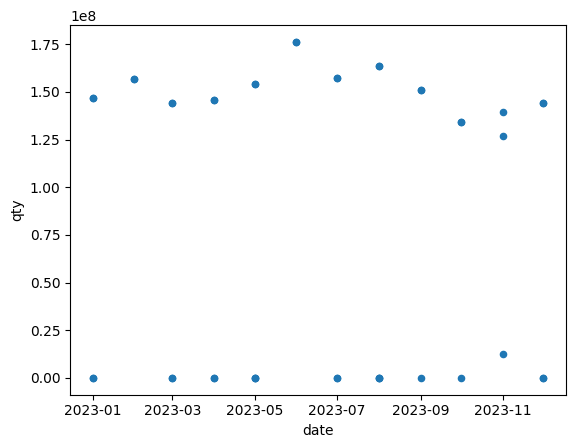

In [220]:
import matplotlib.pyplot as plt
preview_df['date'] = pd.to_datetime(preview_df['period'], format='%Y%m')
y_names = ['qty']
x_name = 'date'
fig, ax = plt.subplots(1,1)
for y_name in y_names:
    ax = preview_df.plot(x=x_name, y=y_name, kind='scatter', ax=ax)

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,M,20231101,2023,11,202311,124,CAN,Canada,X,...,139450000.0,False,0.0,False,None,1.869791e+07,1.869791e+07,0,False,True
1,C,M,20231101,2023,11,202311,124,CAN,Canada,X,...,12700000.0,False,0.0,False,None,1.299058e+06,1.299058e+06,0,False,True
2,C,M,20231101,2023,11,202311,124,CAN,Canada,X,...,126750000.0,False,0.0,False,None,1.739885e+07,1.739885e+07,0,False,True
3,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,144236122.0,False,0.0,False,None,1.926278e+07,1.926278e+07,0,False,True
4,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,22724.0,False,0.0,False,None,3.457670e+03,3.457670e+03,0,False,True
5,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,3398.0,False,0.0,False,None,5.069960e+02,5.069960e+02,0,False,True
6,C,M,20231201,2023,12,202312,124,CAN,Canada,X,...,144210000.0,False,0.0,False,None,1.925882e+07,1.925882e+07,0,False,True


## Obtain dataset

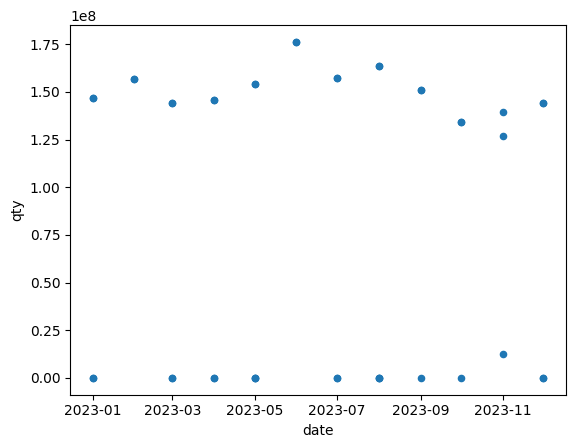

In [220]:
import matplotlib.pyplot as plt
preview_df['date'] = pd.to_datetime(preview_df['period'], format='%Y%m')
y_names = ['qty']
x_name = 'date'
fig, ax = plt.subplots(1,1)
for y_name in y_names:
    ax = preview_df.plot(x=x_name, y=y_name, kind='scatter', ax=ax)

In [ ]:
# obtain data
df = comtradeapicall._getFinalData(
    subscription_key=api_key, 
    typeCode='C', freqCode='A', clCode='HS',
    period=target_periods,
    reporterCode=reporter_code,
    cmdCode=hs_code, flowCode=flow, 
    partnerCode=0, #world/ all partners
    partner2Code=None, customsCode=None,motCode=None,
    breakdownMode='classic', includeDesc=True,
)
df

In [164]:
reporter_code = 124 #cananda
period = '2023'
flow = 'X' # 'M' for Import 'X' for Export
hs_code = '2807'
period_start = '2023-01-01'
period_end = '2023-12-01'

# A list of periods (this is for monthly sets), 
# - this is to optimize the API calls and avoid timeout
periods = pd.date_range(period_start,period_end,freq='MS').strftime("%Y%m").tolist()
target_periods = ",".join(periods)

# obtain data
df = comtradeapicall._getFinalData(
    subscription_key=api_key, 
    typeCode='C', freqCode='A', clCode='HS',
    period=target_periods,
    reporterCode=reporter_code,
    cmdCode=hs_code, flowCode=flow, 
    partnerCode=0, #world/ all partners
    partner2Code=None, customsCode=None,motCode=None,
    breakdownMode='classic', includeDesc=True,
)
df

""


## Testing

In [35]:
#set some variables
from datetime import date
from datetime import timedelta
today = date.today()
yesterday = today - timedelta(days=1)
lastweek = today - timedelta(days=7)

In [41]:
#required
typeCode='C' #C commodity, S services
freqCode='A' #A annual, M monthly
clCode='HS' #Trade (IMTS) classifications: HS, SITC, BEC or EBOPS.

# HS codes : https://www.trade.gov/harmonized-system-hs-codes
# TODO: list them all and fuzzy search using llm
hs_codes = {
    'H2SO4': '2807',
    'NaOH': '281512',
    'Na2SO4': '283311'
}

# A list of periods (this is for monthly sets), 
# - this is to optimize the API calls and avoid timeout
period_start = '2023-01-01'
period_end = '2023-12-01'
periods = pd.date_range(period_start,period_end,freq='MS').strftime("%Y%m").tolist()

In [174]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall

# Replace with your actual subscription key
subscription_key = api_key

# Input parameters
countryCodes = ['CAN']
hsCodes = ['2807', '281512']
flow = 'X'  # Export data

# Get the available months for 2023
df_availableperiods = comtradeapicall.getFinalDataAvailability(
    subscription_key=subscription_key,
    typeCode='C',
    freqCode='A',
    clCode='HS',
    reporterCode=comtradeapicall.convertCountryIso3ToCode('CAN'),
    period='2023'
)
df_availableperiods

,datasetCode,typeCode,freqCode,period,reporterCode,reporterISO,reporterDesc,classificationCode,classificationSearchCode,isOriginalClassification,isExtendedFlowCode,isExtendedPartnerCode,isExtendedPartner2Code,isExtendedCmdCode,isExtendedCustomsCode,isExtendedMotCode,totalRecords,datasetChecksum,firstReleased,lastReleased
0,20124202301202100,C,A,2023,124,CAN,Canada,H6,HS,True,True,True,True,True,False,True,7272087,-237051373,2024-02-14T03:31:37.53,2024-04-25T06:28:26.06


In [175]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall

# Replace with your actual subscription key
subscription_key = api_key

# Input parameters
countryCodes = ['SWE', 'CAN']
hsCodes = ['2807', '281512']
flow = 'X'  # Export data

# Get the available months for 2023
df_availableperiods = comtradeapicall.getFinalDataAvailability(
    subscription_key=subscription_key,
    typeCode='C',
    freqCode='A',
    clCode='HS',
    reporterCode=comtradeapicall.convertCountryIso3ToCode(','.join(countryCodes)),
    period='2022'
)
df_availableperiods["period"] = df_availableperiods["period"].values.astype(str)
targetPeriod_list = ','.join(sorted(df_availableperiods['period'].tolist()))

# Fetch data for each country and product
data_list = []
for country in countryCodes:
    for hsCode in hsCodes:
        df = comtradeapicall._getFinalData(
            subscription_key,
            typeCode='C',
            freqCode='M',
            clCode='HS',
            period=targetPeriod_list,
            reporterCode=comtradeapicall.convertCountryIso3ToCode(country),
            cmdCode=hsCode,
            flowCode=flow,
            partnerCode=0,
            partner2Code=None,
            customsCode=None,
            motCode=None,
            breakdownMode='classic',
            includeDesc=True
        )
        df['country'] = country
        df['hsCode'] = hsCode
        data_list.append(df)

# Combine all data
df_combined = pd.concat(data_list, ignore_index=True)

# Prepare data for plotting
df_plot = df_combined.pivot_table(
    values='primaryValue', 
    index='period', 
    columns=['country', 'hsCode', 'cmdDesc'],
    aggfunc='first'
)

# Plot the data
fig, ax = plt.subplots(figsize=(15, 10))
for column in df_plot.columns:
    ax.plot(df_plot.index, df_plot[column], label=f"{column[0]} - {column[1]}: {column[2][:20]}...")

ax.set_xlabel('Period')
ax.set_ylabel('Primary Value')
ax.set_title('Export Data for Sweden and Canada (2023)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display the data
print(df_plot)

KeyError: 'primaryValue'

In [155]:
reporter_code = 124 #cananda
period = '2023'
flow = 'X' # 'M' for Import 'X' for Export
hs_codes = {
    'H2SO4': '2807',
    'NaOH': '281512',
    'Na2SO4': '283311'
}

cmd_codes = ",".join(hs_codes.values())

df = comtradeapicall._getFinalData(
    subscription_key=api_key, 
    typeCode='C', freqCode='A', clCode='HS',
    period=period,
    reporterCode=reporter_code,
    cmdCode=cmd_codes, flowCode=flow, 
    partnerCode=0, #world/ all partners
    partner2Code=None, customsCode=None,motCode=None,
    breakdownMode='classic', includeDesc=True,
)
df

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20230101,2023,52,2023,124,CAN,Canada,X,...,1.813801e+09,False,0.0,False,None,2.779029e+08,2.779029e+08,0,False,True
1,C,A,20230101,2023,52,2023,124,CAN,Canada,X,...,5.275767e+07,False,0.0,False,None,4.231480e+07,4.231480e+07,0,False,True
2,C,A,20230101,2023,52,2023,124,CAN,Canada,X,...,9.219507e+07,False,0.0,False,None,9.867672e+06,9.867672e+06,0,False,True


In [24]:
import requests
from typing import List, Optional

class ComtradeClient:
    def __init__(self, subscription_key: str, base_url: str = "https://comtradeapi.un.org/data/v1"):
        self.base_url = base_url
        self.subscription_key = subscription_key
        self.headers = {
            "Ocp-Apim-Subscription-Key": self.subscription_key
        }

    def get_trade_data(self, type_code: str, freq_code: str, cl_code: str, **kwargs) -> dict:
        """
        Fetch trade data from the Comtrade API.
        """
        endpoint = f"{self.base_url}/get/{type_code}/{freq_code}/{cl_code}"
        params = {k: v for k, v in kwargs.items() if v is not None}
        response = requests.get(endpoint, headers=self.headers, params=params)
        response.raise_for_status()
        return response.json()

    def get_chemical_groups(self, year: str = "2022") -> List[dict]:
        """
        Get a list of chemical groups that have data.
        
        :param year: The year to check for data availability
        :return: List of dictionaries containing chemical group codes and descriptions
        """
        data = self.get_trade_data(
            type_code='C',
            freq_code='A',
            cl_code='HS',
            period=year,
            cmdCode='28,29',  # Inorganic and Organic chemicals
            aggregateBy='cmdCode'
        )
        
        chemical_groups = []
        for record in data.get('data', []):
            chemical_groups.append({
                'code': record.get('cmdCode'),
                'description': record.get('cmdDesc')
            })
        
        return chemical_groups

    def get_countries_with_data(self, year: str = "2022") -> List[dict]:
        """
        Get a list of countries that have trade data.
        
        :param year: The year to check for data availability
        :return: List of dictionaries containing country codes and names
        """
        data = self.get_trade_data(
            type_code='C',
            freq_code='A',
            cl_code='HS',
            period=year,
            aggregateBy='reporterCode'
        )
        
        countries = []
        for record in data.get('data', []):
            countries.append({
                'code': record.get('reporterCode'),
                'name': record.get('reporterDesc')
            })
        
        return countries

    def get_countries_with_chemical_data(self, chemical_code: str, year: str = "2022") -> List[dict]:
        """
        Get a list of countries that have data for a specific chemical.
        
        :param chemical_code: The HS code for the chemical
        :param year: The year to check for data availability
        :return: List of dictionaries containing country codes and names
        """
        data = self.get_trade_data(
            type_code='C',
            freq_code='A',
            cl_code='HS',
            period=year,
            cmdCode=chemical_code,
            aggregateBy='reporterCode'
        )
        
        countries = []
        for record in data.get('data', []):
            countries.append({
                'code': record.get('reporterCode'),
                'name': record.get('reporterDesc')
            })
        
        return countries

In [25]:

client = ComtradeClient(subscription_key=api_key)
# Get chemical groups
chemical_groups = client.get_chemical_groups()
print("Chemical groups with data:")
for group in chemical_groups[:5]:  # Print first 5 for brevity
    print(f"Code: {group['code']}, Description: {group['description']}")

Chemical groups with data:
Code: -2, Description: None
Code: -2, Description: None
Code: -2, Description: None
Code: -2, Description: None
Code: -2, Description: None


In [ ]:
# Get countries with data
countries = client.get_countries_with_data()
print("\nCountries with trade data:")
for country in countries[:5]:  # Print first 5 for brevity
    print(f"Code: {country['code']}, Name: {country['name']}")

In [ ]:
# Usage example
if __name__ == "__main__":
    client = ComtradeClient('YOUR_SUBSCRIPTION_KEY')

    try:
        # Get chemical groups
        chemical_groups = client.get_chemical_groups()
        print("Chemical groups with data:")
        for group in chemical_groups[:5]:  # Print first 5 for brevity
            print(f"Code: {group['code']}, Description: {group['description']}")

        # Get countries with data
        countries = client.get_countries_with_data()
        print("\nCountries with trade data:")
        for country in countries[:5]:  # Print first 5 for brevity
            print(f"Code: {country['code']}, Name: {country['name']}")

        # Get countries with data for sulfuric acid (HS code 2807)
        countries_with_h2so4 = client.get_countries_with_chemical_data('2807')
        print("\nCountries with sulfuric acid (H2SO4) trade data:")
        for country in countries_with_h2so4[:5]:  # Print first 5 for brevity
            print(f"Code: {country['code']}, Name: {country['name']}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

In [23]:
import pandas as pd
df = pd.DataFrame.from_records(data)
df.describe()

,refPeriodId,refYear,refMonth,reporterCode,partnerCode,partner2Code,aggrLevel,motCode,qtyUnitCode,qty,altQtyUnitCode,altQty,netWgt,grossWgt,cifvalue,fobvalue,primaryValue,legacyEstimationFlag
count,203.0,203.0,203.0,203.0,203.000000,203.0,203.000000,203.0,203.000000,2.030000e+02,203.000000,2.030000e+02,1.970000e+02,203.0,6.300000e+01,2.030000e+02,2.030000e+02,203.000000
mean,20220101.0,2022.0,52.0,842.0,402.576355,0.0,5.320197,0.0,7.911330,1.018874e+08,13.201970,6.760108e+07,5.861084e+07,0.0,3.305326e+07,2.955675e+07,3.088954e+07,0.453202
std,0.0,0.0,0.0,0.0,254.407734,0.0,0.949693,0.0,0.891111,5.151318e+08,6.684813,4.539519e+08,2.888054e+08,0.0,9.638930e+07,1.635007e+08,1.656602e+08,1.576915
min,20220101.0,2022.0,52.0,842.0,0.000000,0.0,4.000000,0.0,-1.000000,0.000000e+00,-1.000000,0.000000e+00,6.100000e+01,0.0,8.430000e+02,8.430000e+02,8.430000e+02,0.000000
25%,20220101.0,2022.0,52.0,842.0,179.000000,0.0,4.000000,0.0,8.000000,1.140250e+04,8.000000,3.025000e+02,9.036000e+03,0.0,6.815100e+04,1.381200e+04,1.381200e+04,0.000000
50%,20220101.0,2022.0,52.0,842.0,384.000000,0.0,6.000000,0.0,8.000000,3.290000e+05,8.000000,1.279400e+04,2.910000e+05,0.0,1.527236e+06,2.062110e+05,2.118850e+05,0.000000
75%,20220101.0,2022.0,52.0,842.0,616.000000,0.0,6.000000,0.0,8.000000,1.920010e+07,21.000000,6.257445e+05,1.426889e+07,0.0,1.561728e+07,5.721215e+06,6.462434e+06,0.000000
max,20220101.0,2022.0,52.0,842.0,862.000000,0.0,6.000000,0.0,8.000000,5.617987e+09,21.000000,5.617882e+09,3.205260e+09,0.0,5.193228e+08,2.023439e+09,2.023439e+09,6.000000


Trade data retrieved successfully:
count: 203
[{'typeCode': 'C', 'freqCode': 'A', 'refPeriodId': 20220101, 'refYear': 2022, 'refMonth': 52, 'period': '2022', 'reporterCode': 842, 'reporterISO': 'USA', 'reporterDesc': 'USA', 'flowCode': 'M', 'flowDesc': 'Import', 'partnerCode': 0, 'partnerISO': 'W00', 'partnerDesc': 'World', 'partner2Code': 0, 'partner2ISO': 'W00', 'partner2Desc': 'World', 'classificationCode': 'H6', 'classificationSearchCode': 'HS', 'isOriginalClassification': True, 'cmdCode': '2807', 'cmdDesc': 'Sulphuric acid; oleum', 'aggrLevel': 4, 'isLeaf': False, 'customsCode': 'C00', 'customsDesc': 'TOTAL CPC', 'mosCode': '0', 'motCode': 0, 'motDesc': 'TOTAL MOT', 'qtyUnitCode': 8, 'qtyUnitAbbr': 'kg', 'qty': 3205260000.0, 'isQtyEstimated': False, 'altQtyUnitCode': 21, 'altQtyUnitAbbr': '1000 KG', 'altQty': 3205260.0, 'isAltQtyEstimated': False, 'netWgt': 3205260000.0, 'isNetWgtEstimated': False, 'grossWgt': 0.0, 'isGrossWgtEstimated': False, 'cifvalue': 510821146.0, 'fobvalue':